# Problem: Property-based Machine Learning
## Taken from AIAP Technical Assessment
## Teo Jun Yean
<hr>

## 1: Data Problem to Solve: Scraping Data

The Requirements: To obtain a good database of Singapore housing data that is consistently up to date

Throughout this Jupyter Notebook, I will be using Python at each level of the pipeline.

The use of () indicates where I could have improved on for better prediction.

The main libraries involved in this tutorial are:

    Pandas for data manipulation and ingestion
    Matplotlib and seaborn for data visualization
    Numpy for multidimensional array computing
    sklearn for machine learning and predictive modeling


## Objectives
### $\bullet$ Data Exploration with Seaborn
### $\bullet$ Data Pre-Processing with Pandas
### $\bullet$ Data Analysis with Algorithms: 1) Linear Regression and 2) Random Forests
### $\bullet$ Analysis of Results
<hr>

In [174]:
# Import libraries

# math library
import numpy as np

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt

# machine learning library
from sklearn.linear_model import LinearRegression

# 3d visualization
from mpl_toolkits.mplot3d import axes3d

# computational time
import time

# Data viz
import seaborn as sns

# Data Library
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely
from shapely.geometry import Point
shapely.speedups.enable()
pd.options.display.max_columns = 100


## 1. Load dataset

Data Set Information:
The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan.

Let us load the training data with Pandas <br>

In [175]:
# import data with Pandas
data = pd.read_excel('AIAP_Dataset/Real estate valuation data set.xlsx')

# number of training data
n = data.shape[0] #YOUR CODE HERE
print('Number of training data and features=',data.shape)
print('Data Features are: ', data.columns.values)

Number of training data and features= (414, 8)
Data Features are:  ['No' 'X1 transaction date' 'X2 house age'
 'X3 distance to the nearest MRT station' 'X4 number of convenience stores'
 'X5 latitude' 'X6 longitude' 'Y house price of unit area']


## 2. Data Cleaning

Using Pandas, we first visualise the first elements of the data

In [176]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


The 6 features as displayed in the table above are:

    X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.) 
    X2=the house age (unit: year)
    X3=the distance to the nearest MRT station (unit: meter)
    X4=the number of convenience stores in the living circle on foot (integer)
    X5=the geographic coordinate, latitude. (unit: degree)
    X6=the geographic coordinate, longitude. (unit: degree)
    The output is as follows
    Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

There are some features that has to be cleaned up.

First, let us re-name the column headers and also to drop the column 'no' as it adds no value.

In Section 2.1, X1 will be ordered categorically.

In Section 2.2, X5 and X6 will be merged to form a new feature.

These parts are explained in their individual sections.

In [177]:
data.rename(columns={'X1 transaction date': 'X1_TransDate', 'X2 house age': 'X2_HouseAge', 'X3 distance to the nearest MRT station': 'X3_distMrt', 'X4 number of convenience stores':'X4_NumConStores', 'X5 latitude': 'X5_Lat', 'X6 longitude':'X6_Lon', 'Y house price of unit area': 'Y_PricePerUnitArea'}, inplace=True)
data.drop(['No'], axis=1, inplace=True)

In [178]:
data = data.sort_values(['X1_TransDate'],ascending=[1]) 
data.describe() #Only numerical features displayed

,X1_TransDate,X2_HouseAge,X3_distMrt,X4_NumConStores,X5_Lat,X6_Lon,Y_PricePerUnitArea
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [179]:
print (data.info()) #No Null Values, all our features are numerical

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 293 to 310
Data columns (total 7 columns):
X1_TransDate          414 non-null float64
X2_HouseAge           414 non-null float64
X3_distMrt            414 non-null float64
X4_NumConStores       414 non-null int64
X5_Lat                414 non-null float64
X6_Lon                414 non-null float64
Y_PricePerUnitArea    414 non-null float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB
None


## 2.1 Transforming X1

The X1 transaction data is based on fractional values, where every 1/12 represents a month. This features has to be cleaned up to correctly represent the months in a categorical manner. If it was left in decimal form, it could be misinterpreted in the training model as a higher value in X1_TransDate means nothing.

In [180]:
data['X1_TransDate'].unique() 

array([ 2012.6666667,  2012.75     ,  2012.8333333,  2012.9166667,
        2013.       ,  2013.0833333,  2013.1666667,  2013.25     ,
        2013.3333333,  2013.4166667,  2013.5      ,  2013.5833333])

There are 12 unique values in this column to be mapped to a categorical value

0 = 2012.6666667 or '2012 Aug'<br>
1 = 2012.75 '2012 Sep'<br>
2 = 2012.8333333 or '2012 Oct' <br>
3 = 2012.9166667 or '2012 Nov' <br>
4 = 2013. or '2012 Dec'<br>
5 = 2013.0833333 or '2013 Jan'<br>
6 = 2013.1666667 or '2013 Feb'<br>
7 = 2013.25 or '2013 Mar'<br>
8 = 2013.3333333 or '2013 Apr'<br>
9 = 2013.4166667 or '2013 May'<br>
10 = 2013.5 or '2013 Jun'<br>
11 = 2013.5833333 or '2013 Jul'<br>

In [181]:
data['X1_TransDate'], mapping_index = pd.Series(data['X1_TransDate']).factorize()
data.head()

,X1_TransDate,X2_HouseAge,X3_distMrt,X4_NumConStores,X5_Lat,X6_Lon,Y_PricePerUnitArea
293,0,12.6,383.2805,7,24.96735,121.54464,42.5
134,0,33.4,186.9686,6,24.96604,121.54211,42.2
383,0,29.1,506.1144,4,24.97845,121.53889,40.3
203,0,15.6,289.3248,5,24.98203,121.54348,46.1
149,0,34.9,179.4538,8,24.97349,121.54245,39.7


## 2.2 Merging X5 and X6

X5 and X6 only make sense if they are taken together into 1 variable. In my mind, this could work similar to zoning structure e.g. zone 1, zone 2 etc. This is done through a GeoDataframe. 

In [182]:
data['X7_Coordinates'] = list(zip(data['X6_Lon'], data['X5_Lat']))
data['X7_Coordinates'] = data['X7_Coordinates'].apply(Point)
data = gpd.GeoDataFrame(data, geometry='X7_Coordinates')
print(data.head()) 

     X1_TransDate  X2_HouseAge  X3_distMrt  X4_NumConStores    X5_Lat  \
293             0         12.6    383.2805                7  24.96735   
134             0         33.4    186.9686                6  24.96604   
383             0         29.1    506.1144                4  24.97845   
203             0         15.6    289.3248                5  24.98203   
149             0         34.9    179.4538                8  24.97349   

        X6_Lon  Y_PricePerUnitArea              X7_Coordinates  
293  121.54464                42.5  POINT (121.54464 24.96735)  
134  121.54211                42.2  POINT (121.54211 24.96604)  
383  121.53889                40.3  POINT (121.53889 24.97845)  
203  121.54348                46.1  POINT (121.54348 24.98203)  
149  121.54245                39.7  POINT (121.54245 24.97349)  


Unfortunately, I was unable to obtain a digital map of the Xindian District alone. The best I could do was to get a Taipei map, which was not granular enough. I also did not have time to adjust the coordinates of the 2 datasets, which clearly do not agree with each other (can be seen from the axes).

Instead, I plotted it out on a normal MatPlotLib in Section 2.3

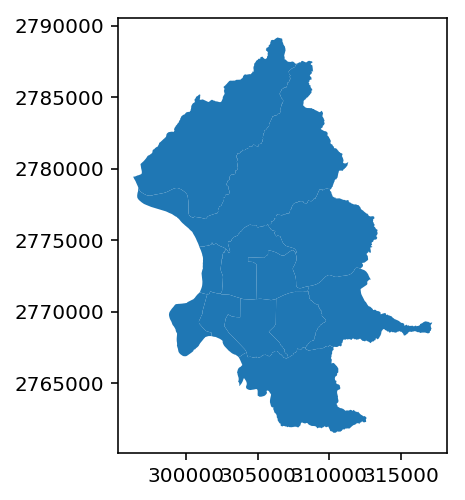

In [183]:
map_link ='AIAP_Dataset/Downloads_Map/G97_A_CADIST_P.shp'
Taipei_map = gpd.read_file(map_link)
Taipei_map.plot()
#map link: https://data.taipei/dataset/detail/metadata?id=1601ef3a-c253-4988-b047-943d9e786143


At this stage, we still cannot really understand the numbers. The next step is to visualise it more specifically. This will be done in Section 2.1.

## 2.3 Explore the dataset distribution with seaborn
<hr>
First, I explore the individual features distribution.

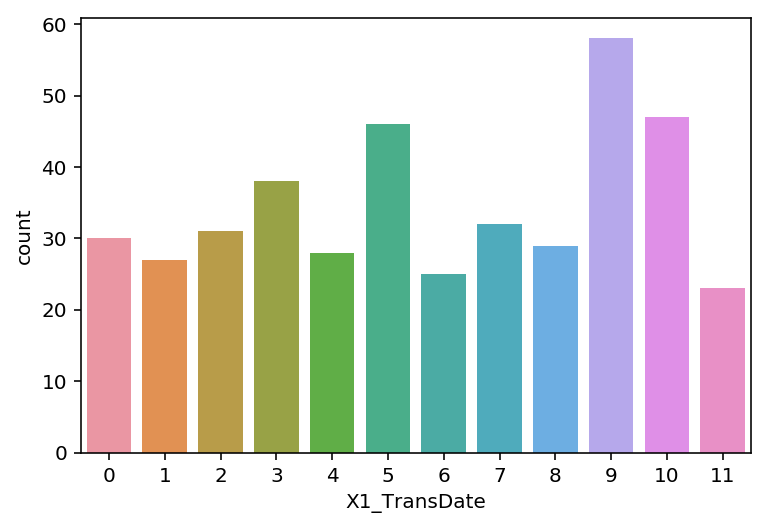

In [95]:
sns.countplot(x='X1_TransDate', data=data) 

a) We see that in some months, such as 2013 May (9), 2013 Jun (10), 2013 Jan (5) houses sold is highest and in 2013 Jul (11) and 2013 Feb (6), it was lowest. <br>
b) We can hypothesise that summer months is the peak period for buying homes, and February is a low period because of Chinese New Year. July is an odd one out, perhaps the Hungry Ghost Festival?

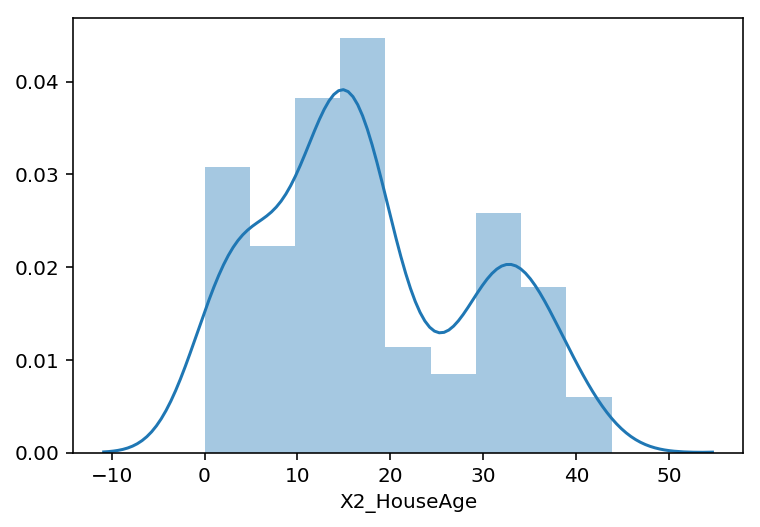

In [96]:
sns.distplot(data['X2_HouseAge']) 

a) Most flats are below 20. Various peaks suggests many houses built together in the same time period. <br>
b) I hypothesise age correlates with geolocation.

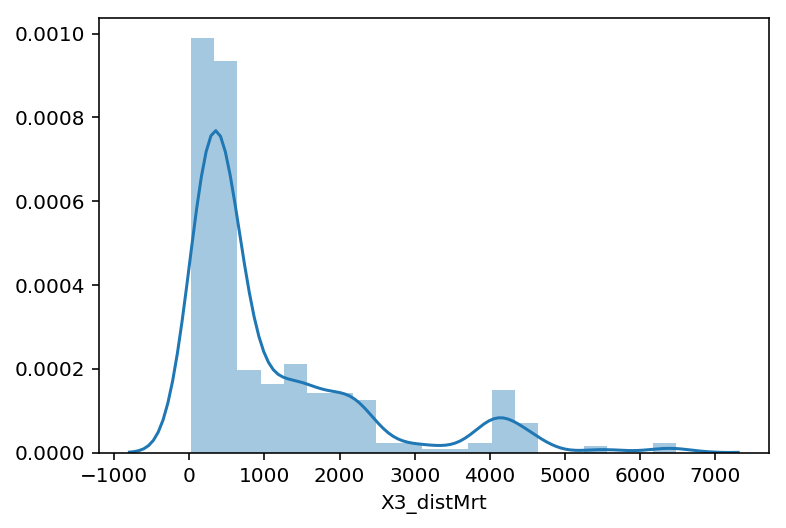

In [97]:
sns.distplot(data['X3_distMrt'])

a) Most are near the MRT
b) I hypothesise the ones further are cheaper
c) Also correlates with geolocation

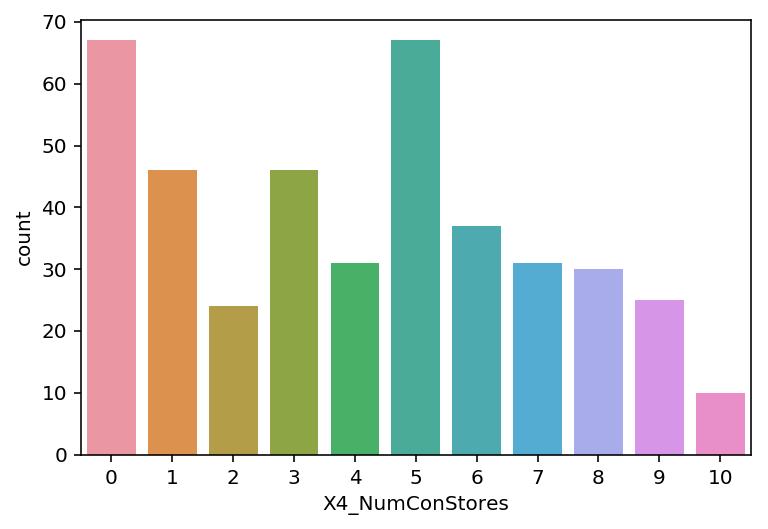

In [98]:
sns.countplot(x='X4_NumConStores', data=data) 

This could also correlate with geolocation, where a high number of houses are situated in the same high-rise apartments, such that the convenience stores near them are similar

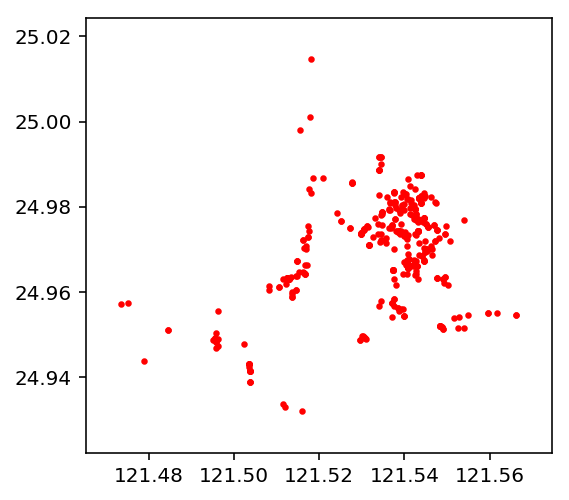

In [184]:
data.plot(marker='o', color='red', markersize=5)

a) This is the geolocation of all the houses in our dataset<br>
b) Clearly our dataset is skewed towards the middle-right of the graph, where most houses are congregated.<br>
c) This affects our other data features that are location-based too such as X3_distMRT

Clearly, some features (e.g. coordinates and age) are skewed in the dataset, which could be a limitation for our model. Next, I explore correlations of the data features.<br>

## 2.3 Exploring the correlation between features


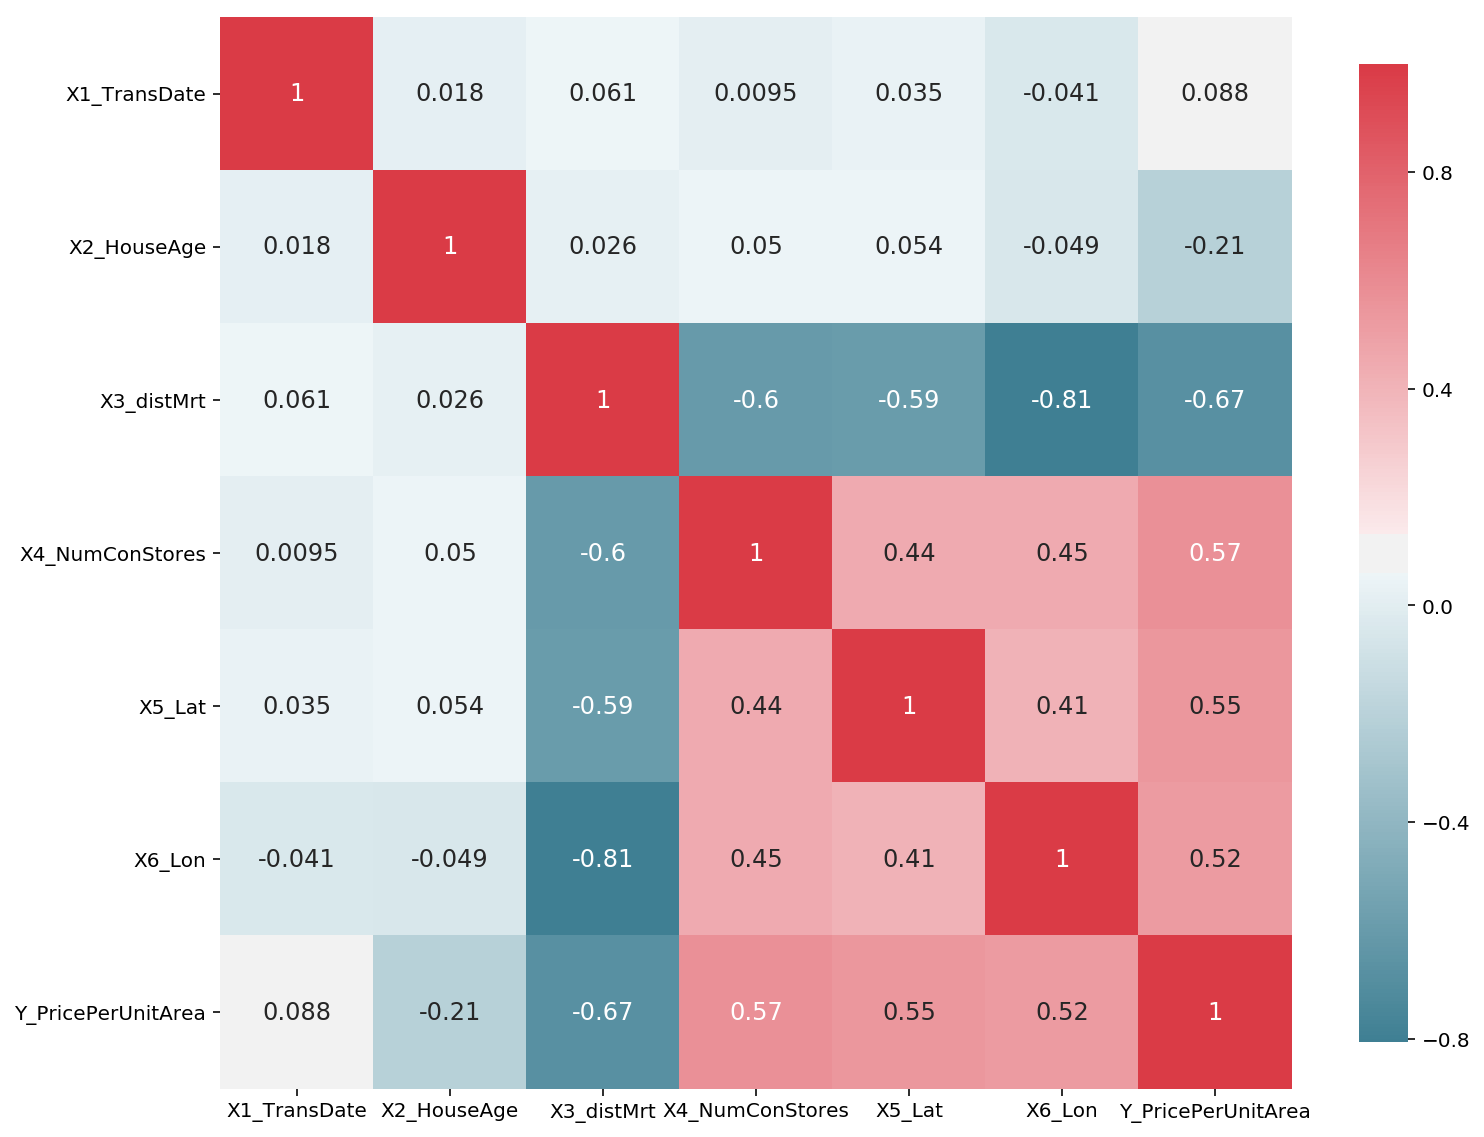

In [185]:
def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
plot_correlation_map(data)
#This only shows numerical features. 

This heatmap gives us a basic idea of important numerical variables. Indeed, we find a few interesting correlations that are actualy quite intuitive. A value higher to 1 indicates higher correlation, while closer to 0 means less. 

A few examples in descending order: <br>
At <b>-0.81</b>, <i>X6_Lon</i> and <i>X3_distMRT</i> has the highest correlation among our features here. Clearly, intuition tells us that the higher the longitude of the property, the further the trains are from it. This is something we have to take note of, as this high relation suggests one of it (probably longitude) might be redundant<br>

At <b>-0.67</b>, <i>X3_distMRT</i> and <i>Y_PricePerUnitArea</i>. As they say in property prices, location matters. A higher distance from the MRT should give you more inconvenience, causing you to value the property lesser, which explains the negative correlation i.e distance increases, Price Per Unit Area decreases. <br>

At <b>-0.6</b>, <i>X3_distMRT</i> and <i>X4_NumConStores</i>, the further you go from the MRT, the less convenience stores there'll be around you. This makes sense as convenience stores want to be in places with high footfall; thus they congregate around MRT stations. This could be considered to be dropped due to high correlation, which may affect our model <br>

At <b>0.57</b>, <i>Y_PricePerUnitArea</i> and <i>X4_NumConStores</i>, property buyers would want to live in a district where everything is near, adding to the value of the property. Therefore, with more convenience stores around them, the property value should increase <br>

However, this heatmap only includes numerical variables, not categorial variables that are not purely numerical such as the features 'X1_TransDate' and 'X7_Coordinates'. These are explored next.

# 2.1.1 Further Exploration of Features 

### Transaction Date vs Price

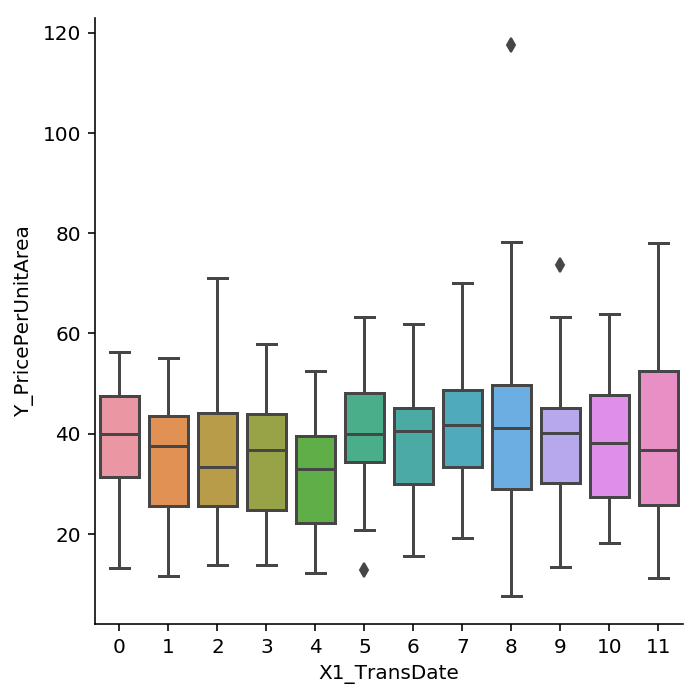

In [186]:
sns.catplot(x="X1_TransDate", y="Y_PricePerUnitArea", kind="box", data=data);

a) This reflects monthly trends. with 5 being January. From this boxplot, House Prices picks up early in the year, then goes down after summer.<br>
b) Also notice outliers to remove i.e points off the box that will affect the accuracy of our predictive algorithm

### Geolocation vs Price

This will be an important predictor. However, I went too deep down the wrong path, and realised I could not successfully groupBy these datapoints for meaningful data extraction. Thankfully, I still have longitude and latitude in the dataframe.

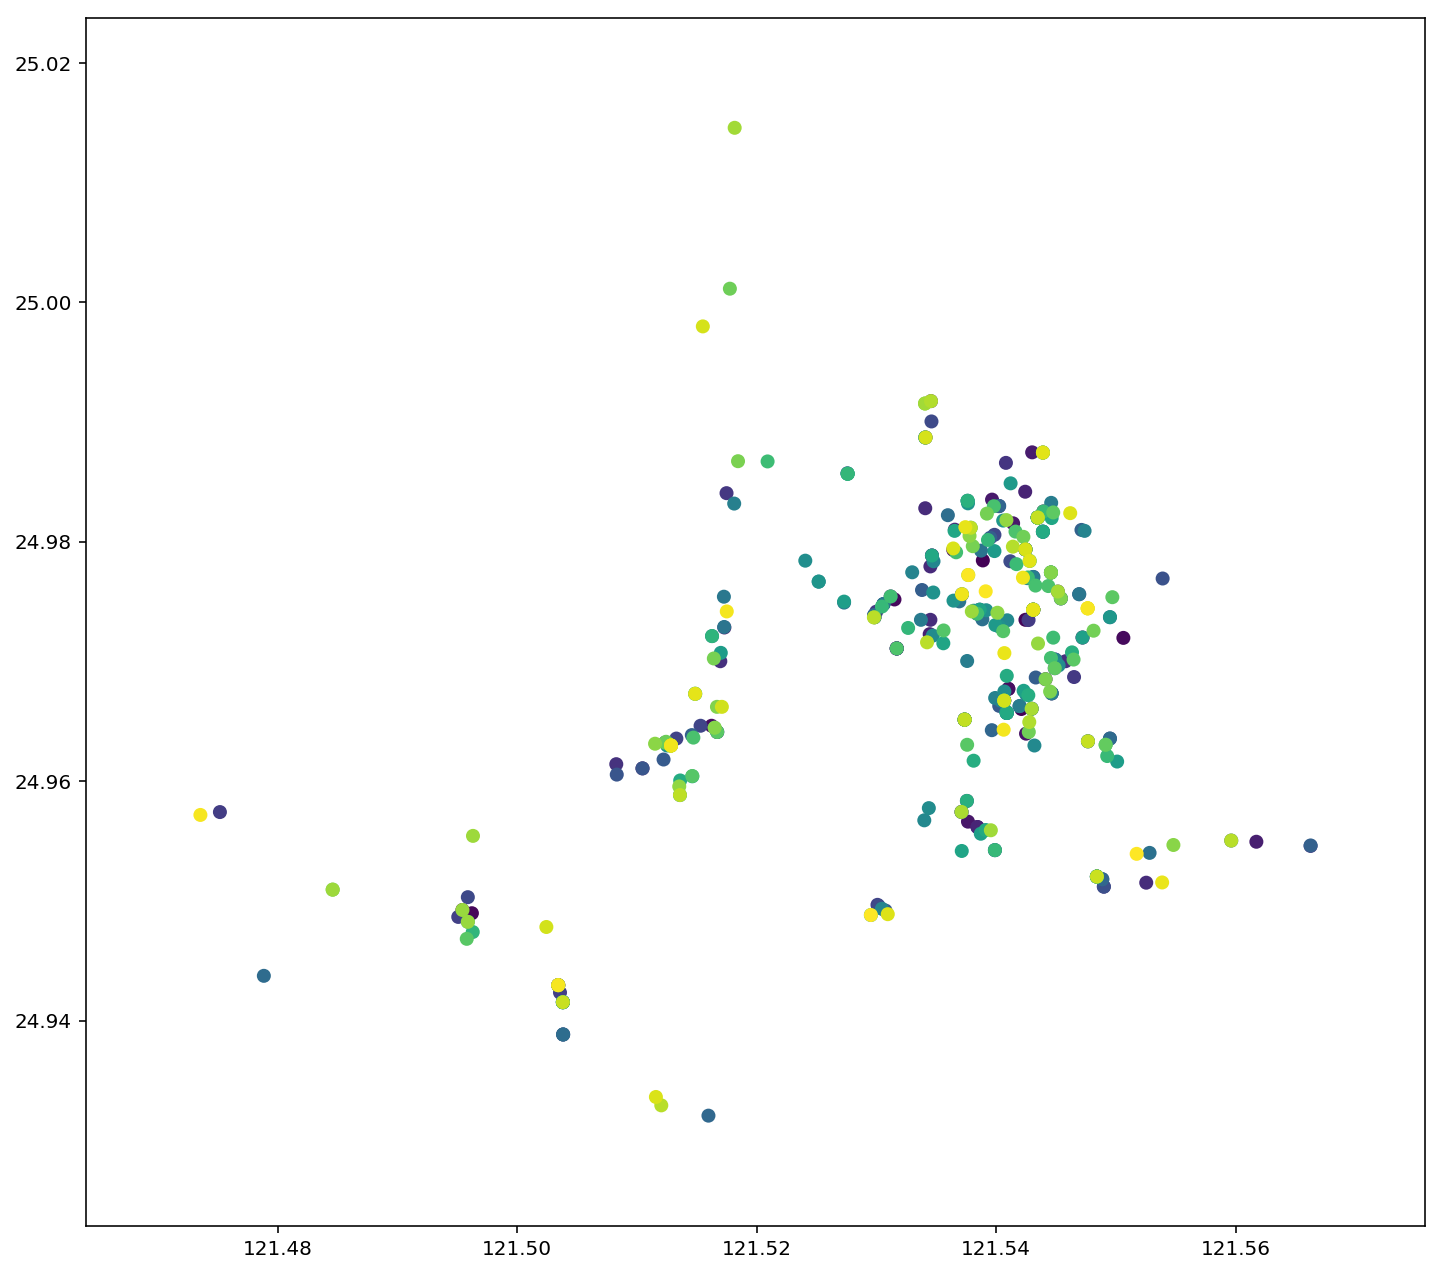

In [187]:
data.plot(figsize = (12,12), c='Y_PricePerUnitArea',
                       cmap='viridis', legend=True)

## Section 2.3: Concluding Remarks for Data Visualisation

### a) Completing

Data points were all filled <br>
<b> X1 was converted into categorical to better reflect its nature </b> 

### b) Correlating

We want to know how well does each feature correlate with Y_PricePerUnitArea in order to decide which features to retain. 

<b>Unfortunately, the X7_Coordinates feature was unable to be used, due in part to a lack of experience with that particular library and also a lack of time to explore</b>

### c) Correcting

At first glance, these features seem unimportant intuitively and for ease of feature engineering, should be dropped to prevent overfitting. <br>
- X6_Lon <br>
- X5_Lat <br>
- X7_Coordinates <br>

() I tried to use groupBy for X6_Lon and X5_Lon, but I could not get it to work within the remaining time I had. I also know that coordinates can be important for their proximity to other attractions such as parks or malls that were not inside.  Their correlation to price however, was lower than other geo-spatial predictors, hence I dropped them. <br><br></br>

Concluding our preliminary data visualisation, we shall now proceed to feature engineering based on these insights.

## 3. Feature Engineering
<hr>

### 3.1 Dropping Variables

In [188]:
data.drop(['X5_Lat', 'X6_Lon', 'X7_Coordinates'], axis=1, inplace = True)

In [189]:
data.head()

,X1_TransDate,X2_HouseAge,X3_distMrt,X4_NumConStores,Y_PricePerUnitArea
293,0,12.6,383.2805,7,42.5
134,0,33.4,186.9686,6,42.2
383,0,29.1,506.1144,4,40.3
203,0,15.6,289.3248,5,46.1
149,0,34.9,179.4538,8,39.7


() Perhaps these categories of Age can be further refined.

() Might need to learn a more sophisticated way of feature selection. Still not sure what is a good feature or bad feature beyond intuition. 

## 4. Linear Regression
<hr>

Our algorithm choice to solve this is using Linear Regression to predict housing prices based on 4 selected features as seen in Section 3. 

In [190]:
from sklearn import datasets, linear_model 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from math import sqrt


df = pd.DataFrame(data) # load the dataset as a pandas data frame from geodataframe
y = df.Y_PricePerUnitArea # define the target variable (dependent variable) as y

df.drop(['Y_PricePerUnitArea'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(331, 4) (331,)
(83, 4) (83,)


Cross-validated scores: [ 0.78249436  0.63739749  0.53510468  0.52117571  0.34456553  0.52529147]
Score:  0.477460687124
RMSE:  8.520981724629355
RMAE:  2.545642076979615


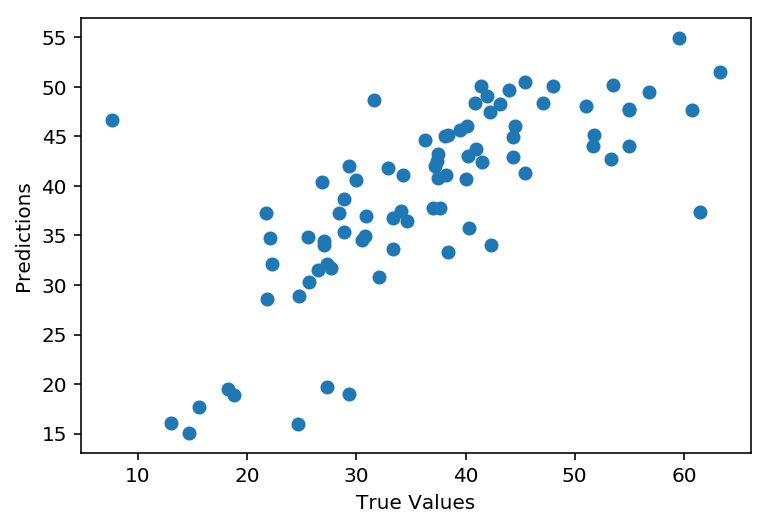

In [191]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
y_actual = lm.predict(X_test)

scores = cross_val_score(model, df, y, cv=6)
print ('Cross-validated scores:', scores)

## The line / model
plt.scatter(y_test, y_actual)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print ('Score: ', model.score(X_test, y_test))
print ('RMSE: ', sqrt(mean_squared_error(y_actual, y_test))) #Generally poorer performance since there're outliers that can skew the prediction, which I forgot to remove
print ('RMAE: ', sqrt(mean_absolute_error(y_actual, y_test))) 

The accuracy score is really bad because it does not follow a line. Let us now try a different model. 

## 5. Trying Other Algorithms: Random Forest
<hr>


In [192]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0,
                            n_estimators=100)

scores = cross_val_score(regr.fit(X_train, y_train), df, y, cv=6)
print ('Cross-validated scores:', scores)

print('RandomForestScore = ', regr.score(X_test, y_test))
print ('RMSE: ', sqrt(mean_squared_error(y_actual, y_test))) #Generally poorer performance since there're outliers that can skew the prediction, which I forgot to remove
print ('RMAE: ', sqrt(mean_absolute_error(y_actual, y_test)))


Cross-validated scores: [ 0.69668269  0.71866405  0.62942139  0.58476371  0.43162371  0.64074731]
RandomForestScore =  0.574526105635
RMSE:  8.520981724629355
RMAE:  2.545642076979615


But perhaps the model was overfitted with 100 decision trees. Next, let us optimise this Random Forest with some different parameter combinations.

In [194]:
from sklearn.model_selection import GridSearchCV

forest=RandomForestRegressor()

n_estimators = [3,6,9,12,15]
max_features = [0.1,0.25,0.5,0.75,0.99]
max_depth = [3,6,9,12,15]

gsf = GridSearchCV(forest, {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}, cv=5)
gsf.fit(X_train, y_train)
gsf.best_params_

y_pred = gsf.best_estimator_.predict(X_test)

print(gsf.best_params_)

{'max_depth': 6, 'max_features': 0.99, 'n_estimators': 9}


Based on the output of the above cell in that 1 test, input it into the one below. This varies at each run however.

In [195]:
regr = RandomForestRegressor(n_estimators=6, max_features=0.5, max_depth=12)

scores = cross_val_score(regr.fit(X_train, y_train), df, y, cv=6)
print ('Cross-validated scores:', scores)

print('RandomForestScore = ', regr.score(X_test, y_test))
print ('RMSE: ', sqrt(mean_squared_error(y_actual, y_test))) #Generally poorer performance since there're outliers that can skew the prediction, which I forgot to remove
print ('RMAE: ', sqrt(mean_absolute_error(y_actual, y_test)))

Cross-validated scores: [ 0.64356636  0.76150307  0.71761747  0.64054124  0.41000081  0.54600481]
RandomForestScore =  0.578302837757
RMSE:  8.520981724629355
RMAE:  2.545642076979615


This example shows how the tuning of hyper-parameters can greatly improve accuracy.

## 6. Conclusion

In this project, I analysed 7 predictors of housing prices. From the preliminary correlations, we saw that 1) location-based variables scored the highest in predicting housing prices.

We then tried 2 classifiers, namely Linear Regression and Random Forest, in order to accurately predict housing given a set of features. Due to the dropping of a few important features, coupled with my inexperience in feature engineering, the model's predictive accuracy were not high. 

RMSE often showed a higher error than MAE as the mathematical property of squaring these numbers, especially in the face of outliers, causes RMSE to have higher errors.

The Random Forest performed better, not just because of the tuning of hyper-parameters, but also because a linear regression is too simple to predict housing prices. A slightly more complex model, such as a Random Forest, performed better due to the nature of the data.

In hindsight, these aspects of the project could have been improved upon:

### Feature Engineering
- Handling outliers in the y-variable
- Not dropping geo-location features because they can have some useful predictive utility
- Better understanding the context of these features e.g. visualing the property on a map
- More experience in using spatial libraries such as GeoDataframe, so new features could have been engineered + I could have used GroupBy successfully

### Algorithm Selection
- Better understanding Random Forests because it has a lot of potential in predicting this problem. We only implemented the most basic version of it.

### Coding
- Comments, comments, comments. 